In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

np.set_printoptions(suppress=True, precision=5)

from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score


# ロジスティック回帰スクラッチ

In [317]:
class ScratchLogisticRegression():
    """
    ロジスティック回帰のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    no_bias : bool
      バイアス項を入れない場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      パラメータ
    self.loss : 次の形のndarray, shape (self.iter,)
      訓練データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証データに対する損失の記録

    """
    def __init__(self, num_iter=50, lr=0.01, no_bias=False, C=1.0, verbose=False, debug=False):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.no_bias = no_bias
        self.C = C
        self.verbose = verbose
        # 損失を記録する配列を用意
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)
        
        #★★デバッグデータ★★
        self.debug = debug
        self.test_data = np.array([0.2, -0.3, 0.1]) 
        
        
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ロジスティック回帰を学習する。検証データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        
        # 検証データの計算を行うかどうか
        is_val_calc = (X_val is not None) and (y_val is not None)
        
        # データ前処理
        X, y  = self._data_processing(X, y)
        if is_val_calc:
            X_val, y_val  = self._data_processing(X_val, y_val)
        
        #パラメータθを特徴量数に合わせて作成
        if self.debug:
            self.coef_ = self.test_data
        else:
            self.coef_ = np.array(np.random.normal(0, 1, X.shape[1]))
        
        if self.debug:
            print("default theta:", self.coef_)
            print("default ploba:", self.predict_proba(X[:, 1:]).flatten())
            print()
        
        # イテレータ数,学習を繰り返す
        for i in range(self.iter):
            self._gradient_descent(X, y)
            self.loss[i] = self._loss(X, y)
            
            if is_val_calc:
                self.val_loss[i] = self._loss(X_val, y_val)
            
            if self.verbose:
                #verboseをTrueにした際は学習過程を出力
                print("iter: {}  coef:{}".format(i+1, self.coef_))
                print("probability:", self.predict_proba(X[:, 1:]).flatten())
                print("loss:", self.loss)
                print()
        pass

    def predict(self, X):
        """
        ロジスティック回帰を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        
        X, _ = self._data_processing(X)
        pred = self._logistic_hypothesis(X)
        pred = np.round(pred).astype(int).flatten()
        
        return pred
    
    def predict_proba(self, X):
        """
        ロジスティック回帰を使い確率を推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        X, _ = self._data_processing(X)
        pred = self._logistic_hypothesis(X).flatten()
        
        return pred
    
    def _data_processing(self, X, y=None):
        # データセットがDataFrame, Seriesの場合ndarrayに変換する
        if isinstance(X, (pd.DataFrame, pd.Series)):
            X = X.values
        if isinstance(y, (pd.DataFrame, pd.Series)):
            y = y.values
        
        # データセットが1次元の場合、2次元に変換する
        if X.shape[0] == X.size:
            X = X.reshape(-1, 1)
        
        if y is not None:
            y = y.reshape(-1, 1)

        # 特徴量のサンプル数をセット
        m = X.shape[0]
        
        # バイアス項の追加
        if self.no_bias:
            n = X.shape[1]
        else:
            n = X.shape[1] + 1
            # Xに切片の(x=1)を追加
            X = np.concatenate((np.ones((m, 1)), X), axis=1)

        return X, y
    
    def _sigmoid(self, X):
        return 1 / (1 + np.exp(-X))
    
    def _logistic_hypothesis(self, X):
        linear_format = np.sum(self.coef_* X, axis=1).reshape(-1, 1)
        h_theta = self._sigmoid(linear_format)
        
        return h_theta
    
    def _gradient_descent(self, X, y):
        """
        パラメータθを勾配方向に更新する
        
         Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          訓練データ
        y : 次の形のndarray, shape (n_samples, )
          訓練データの正解値

        """
        m = len(X)
        
        grad = np.average(self._error(X, y) * X, axis=0)
        tmp = grad[0]
        
        grad = np.average(self._error(X, y) * X, axis=0) + (self.C * self.coef_ / m)
        grad[0] = tmp
        
        self.coef_ = self.coef_ - self.lr * grad
        
    def _error(self, X, y):
        """
        予測値と実際値の誤差を計算する関数

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          訓練データ
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        
        Returns
        -------
          次の形のndarray, shape (n_samples, 1)
          予測値と実際値の誤差

        """
        return self._logistic_hypothesis(X) - y

    def _loss(self, X, y):
        """
        損失関数を計算する

         Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          訓練データ
        y : 次の形のndarray, shape (n_samples, )
          訓練データの正解値

        """

        m = len(X)
        start = 0 if self.no_bias else 1
        
        h_X = self._logistic_hypothesis(X)
        loss = np.average((-y * np.log(h_X)) - ((1 - y) * np.log(1 - h_X)))
        J_theta =  loss + self.C * np.sum(self.coef_[start:] ** 2) / (2 * m)

        if self.debug:
            print("loss", loss)
            print("J_theta:", J_theta)
        
        return J_theta

## 【問題1】仮定関数
ロジスティック回帰の仮定関数のメソッドをScratchLogisticRegressionクラスに実装してください。

ロジスティック回帰の仮定関数は、線形回帰の仮定関数を シグモイド関数 に通したものです。シグモイド関数は以下の式で表されます。

$g(z) = \frac{1}{1+e^{−z}}$

線形回帰の仮定関数は次の式でした。

$h_\theta(x) = \theta^T \cdot x$

まとめて書くと、ロジスティック回帰の仮定関数は次のようになります。

$h_\theta(x) = \frac{1}{1+e^{−\theta^T \cdot x}}$

$x$ : 特徴量ベクトル


$\theta$ : パラメータ（重み）ベクトル



## 【問題2】最急降下法
最急降下法により学習させる実装を行なってください。以下の式で表されるパラメータの更新式のメソッド_gradient_descentを追加し、fit
メソッドから呼び出すようにしてください。

$\theta_j := \theta_j - \alpha \frac{\partial J(\theta)}{\partial \theta_j}\\<br/>\frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m}  \sum_{i=1}^{m}(h_θ(x^{(i)}) − y^{(i)})x_j^{(i)}  ,j = 0\\<br/>\frac{\partial J(\theta)}{\partial \theta_j} = \biggl(\frac{1}{m}  \sum_{i=1}^{m}(h_θ(x^{(i)}) − y^{(i)})x_j^{(i)} \biggr) + \frac{λ}{m}\theta_j　 ,j\geq 1$

$\alpha$ : 学習率


$i$ : サンプルのインデックス


$j$ : 特徴量のインデックス


$m$ : 入力されるデータの数


$h_\theta()$ : 仮定関数


$x$ : 特徴量ベクトル


$\theta$ : パラメータ（重み）ベクトル


$x^{(i)}$ : i番目のサンプルの特徴量ベクトル


$y^{(i)}$ : i番目のサンプルの正解ラベル


$\theta_j$ : j番目のパラメータ（重み）


$λ$ : 正則化パラメータ

## 【問題3】推定
推定する仕組みを実装してください。ScratchLogisticRegressionクラスの雛形に含まれるpredictメソッドとpredict_probaメソッドに書き加えてください。

仮定関数 
$hθ(x)$
 の出力がpredict_probaの返り値、さらにその値に閾値を設けて1と0のラベルとしたものがpredictの返り値となります。

## 【問題4】目的関数
以下の数式で表されるロジスティック回帰の 目的関数（損失関数） を実装してください。

そして、これをself.loss, self.val_lossに記録するようにしてください。

なお、この数式には正則化項が含まれています。

$J(\theta)=  \frac{1}{m}  \sum_{i=1}^{m}[−y^{(i)} log(h_θ(x^{(i)})) − (1−y^{(i)}) log(1−h_θ(x^{(i)}))] +
\frac{λ}{2m}\sum_{j=1}^n
θ^2_j$


In [321]:
# デバッグデータ
X_train = np.array([[-6, -4], 
             [2, 4],
             [6, 8]])

y_train = np.array([0, 1, 1])
X_test  = np.array([[3, 5],
                    [-4, 2]])


lr = ScratchLogisticRegression(num_iter=5, lr=0.01, C=2, verbose=True ,debug=True)
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
pred_prob = lr.predict_proba(X_test)

print("pred:", pred)
print("pred_prob:", pred_prob)

default theta: [ 0.2 -0.3  0.1]
default ploba: [0.83202 0.5     0.31003]

loss 0.9812493147435388
J_theta: 1.0106406921347924
iter: 1  coef:[ 0.20119 -0.26423  0.13549]
probability: [0.77636 0.55347 0.4255 ]
loss: [1.01064 0.      0.      0.      0.     ]

loss 0.8010915698514743
J_theta: 0.8283149803176726
iter: 2  coef:[ 0.20201 -0.23247  0.16621]
probability: [0.71748 0.59915 0.53417]
loss: [1.01064 0.82831 0.      0.      0.     ]

loss 0.6653787145913778
J_theta: 0.691674472451689
iter: 3  coef:[ 0.20251 -0.20458  0.19244]
probability: [0.65932 0.63717 0.62587]
loss: [1.01064 0.82831 0.69167 0.      0.     ]

loss 0.5630919671449031
J_theta: 0.5892820128296266
iter: 4  coef:[ 0.20276 -0.18013  0.21476]
probability: [0.60456 0.66853 0.69848]
loss: [1.01064 0.82831 0.69167 0.58928 0.     ]

loss 0.485047029219875
J_theta: 0.5116604157792328
iter: 5  coef:[ 0.20286 -0.1586   0.23385]
probability: [0.55454 0.69446 0.75437]
loss: [1.01064 0.82831 0.69167 0.58928 0.51166]

pred: [1 1]
p

## 【問題5】学習と推定
機械学習スクラッチ入門のSprintで用意したirisデータセットのvirgicolorとvirginicaの2値分類に対してスクラッチ実装の学習と推定を行なってください。

scikit-learnによる実装と比べ、正しく動いているかを確認してください。

AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

In [391]:
# アイリスデータの読み込み
iris = load_iris()

# 特徴量はX1（Petallength）、X2（petalwidth）を選択し学習を行う
train_x = iris.data[50:, 2:]
train_y = iris.target[50:]
train_y = np.array(list(map(lambda x: x-1, train_y)))

# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, random_state=42)

# 標準化
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [403]:
# ハイパーパラメータの設定
num_iter = 5000
alpha = 0.1
C = 1.0

# モデルを定義
scratch_lr = ScratchLogisticRegression(num_iter=num_iter ,lr=alpha, C=C, verbose=False)
sklearn_lr = LogisticRegression()

model = {"scratch_LR": scratch_lr, "sklearn_LR": sklearn_lr}
results = pd.DataFrame(columns=["model_name", "accuracy_score", "precicion_score", "recall_score"])

# 学習と予測
i = 0
for name, model in model.items():
    
    if name == "scratch_LR":
        model.fit(X_train, y_train, X_test, y_test)
    else:
        model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    print(f"{name} predict:", y_pred)
    
    acc_score = accuracy_score(y_test, y_pred)
    pre_score = precision_score(y_test, y_pred)
    rec_score = recall_score(y_test, y_pred)
    
    results.loc[i, :] = [name, acc_score, pre_score, rec_score]
    i += 1

display(results)

scratch_LR predict: [0 1 1 0 0 0 0 1 0 0 0 0 1 1 1 0 1 1 0 0 1 1 0 0 0]
sklearn_LR predict: [0 1 1 0 0 0 0 1 0 0 0 0 1 1 1 0 1 1 0 0 1 1 0 0 0]


,model_name,accuracy_score,precicion_score,recall_score
0,scratch_LR,0.88,0.9,0.818182
1,sklearn_LR,0.88,0.9,0.818182


同じ結果となったので実装に問題なさそう

## 【問題6】学習曲線のプロット
学習曲線を見て損失が適切に下がっているかどうか確認してください。

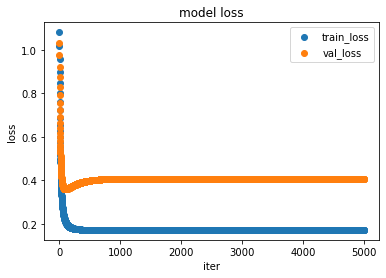

In [393]:
iter_list = list(range(num_iter))
scratch_train_loss = scratch_lr.loss
scratch_val_loss = scratch_lr.val_loss

plt.scatter(iter_list, scratch_train_loss, label="train_loss")
plt.scatter(iter_list, scratch_val_loss, label="val_loss")
plt.xlabel("iter")
plt.ylabel("loss")
plt.title("model loss")
plt.legend()
plt.show()

## 【問題7】決定領域の可視化
決定領域を可視化してください。

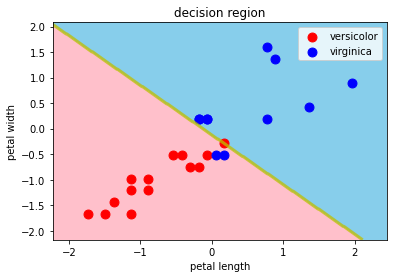

In [401]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

    
decision_region(X_test, y_test, scratch_lr, xlabel="petal length", ylabel="petal width")    

## 【問題8】（アドバンス課題）重みの保存
検証が容易になるように、学習した重みを保存および読み込みができるようにしましょう。pickleモジュールやNumPyのnp.savezを利用します。